# This checks the error in the testing split of the data

In [1]:
%matplotlib inline
import os
import sys
# Add the directory containing your module to the Python path
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml'))
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities/Model_tests'))
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities'))
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pickle as pkl
import numpy as np
import pandas as pd
import keras
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from test_case.neural import change_layers
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
import gzip
randint = 58
keras.utils.set_random_seed(randint)
keras.backend.set_floatx('float64')
keras.config.set_floatx('float64')


2024-11-01 22:58:30.664382: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 22:58:31.651578: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 22:58:32.625123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 22:58:48.915865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load in Data
Read in the random trajectories

In [2]:
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))
random_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))
#data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))


In [3]:
new_random_data = pkl.load(gzip.open('new_training_data.pkl.gz', 'rb'))

In [4]:
directory_placeholder = []
for _ in range(19502):
    directory_placeholder.append('0.5_random_trajectory')
np.shape(directory_placeholder)
new_random_data['directory'] =  directory_placeholder
new_random_data.shape

(19502, 26)

In [5]:
random_data = pd.concat([random_data, new_random_data], sort=False)

In [6]:
with open(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'featurizer.pkl'), 'rb') as fp:
    featurizer = pkl.load(fp)

x_labels = list(featurizer.feature_labels())

print(x_labels)

['charge density at t=-4.00', 'charge density at t=-3.00', 'charge density at t=-2.00', 'charge density at t=-1.00', 'charge density at t=-0.50', 'charge density at t=0.00', 'charge density at t=0.50', 'charge density at t=1.00', 'charge density at t=2.00', 'AGNI projected eta=8.00e-01', 'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00', 'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00', 'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01', 'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag']


In [7]:
x = pd.concat([channel_data[x_labels], random_data[x_labels]], sort=False)
y = pd.concat([channel_data['force'], random_data['force']], sort=False)
print(x.shape)
print(y.shape)
print(x.columns)

(169541, 19)
(169541,)
Index(['charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00', 'AGNI projected eta=8.00e-01',
       'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00',
       'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00',
       'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01',
       'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag'],
      dtype='object')


## Split the data into training, validation, and testing categotries 

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(118678, 19) (118678,)
(25431, 19) (25431,)
(25432, 19) (25432,)


# Scale the data

In [9]:
model = keras.models.load_model('model_new.h5')

2024-11-01 22:59:36.729357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-01 22:59:36.797296: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: ccc0351.campuscluster.illinois.edu
2024-11-01 22:59:36.797314: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: ccc0351.campuscluster.illinois.edu
2024-11-01 22:59:36.854596: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.23.8
2024-11-01 22:59:36.854641: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 545.23.8
2024-11-01 22:59:36.854650: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 545.23.8


<!-- ## Save Data
For later plotting purposes -->

# Generalization on Random

In [10]:

x_label2 = list(featurizer.feature_labels())
x_label2.append('displacement')
x_label2.append('directory')


In [11]:
 x = pd.concat([channel_data[x_label2], random_data[x_label2]], sort=False)
 y = pd.concat([channel_data['force'], random_data['force']], sort=False)


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test1, y_val, y_test1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

data_1 = pd.DataFrame(X_test1, columns = x_label2)
x_label_3 = x_label2.copy()
x_label_3.append('force')
data = data_1.merge(random_data, on=x_label2, how='inner')

y_pred = model.predict(data[x_labels])
rand_test =  mean_absolute_error(data['force'], y_pred)
print()
print('The mae on the random trajectory: ', rand_test)
print('On average, the predictions are off by 0.012646813826935829 units from the actual values')
print()
print('minimum target value: ',data['force'].min(0))
print('maximum target value: ', data['force'].max(0))
print('mean of target value: ', data['force'].mean(0))
print('std of target value: ', data['force'].std(0))
print('variance of target value: ', data['force'].var(0))

619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step

The mae on the random trajectory:  0.012306652807506585
On average, the predictions are off by 0.012646813826935829 units from the actual values

minimum target value:  -419.83674883524424
maximum target value:  422.8931025718002
mean of target value:  0.19083845500256233
std of target value:  6.8451988207460985
variance of target value:  46.85674689554378


In [29]:
def plot_performance(model, split_v):
    """Evaluate and plot the performance of the model on multiple velocities
    
    Args:
        model (keras.Model): Model to be trained
        data (pd.Dataframe): Training set
    """

    # Evaluate on the whole dataset
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_novel], data[X_cols_vel]])
    else:
        data['force_fit'] = model.predict(data[x_labels])        

    # Plot results
    fig, axs = plt.subplots(1, 3)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in axs[:2]:
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement (a.u.)')
            a.set_ylabel('Force ($E_H / a_B$)')
        
        # Store the stopping powers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    axs[2].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    axs[2].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    axs[2].set_ylabel('Stopping Power ($E_H / a_B$)')
    axs[2].set_xlabel('Velocity (au.)')
    #axs[2].set_ylim(0, max(axs[2].get_ylim()))
    axs[2].set_xlim(0, 12)
    #axs[2].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    # Print the MAPE
    stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
    print(f'Mean percent error: {stopping_mape * 100:.2f}%')
    
    return fig, axs, data

619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
Mean percent error: 5.59%


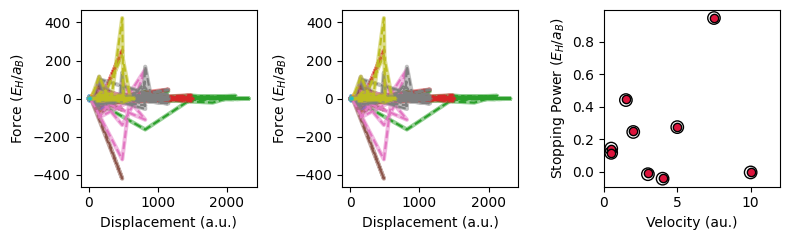

3372/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3452/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step


Mean percent error: 2.05%


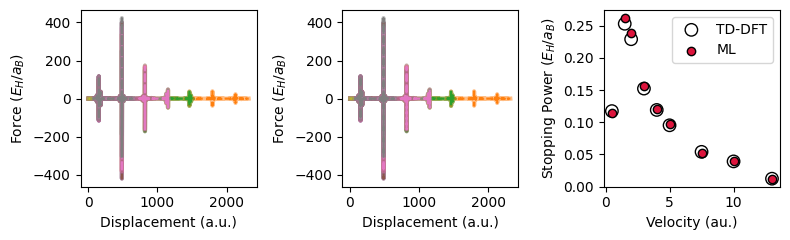

In [30]:
fig, ax, data = plot_performance(model, False)
#data.to_csv(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'fit-random-predict-random.csv'), index=False)

# Generalization on channel

In [15]:
channelling_data = data_1.merge(channel_data, on=x_label2, how='inner')
channelling_data['force_fit'] = model.predict(channelling_data[x_labels])

y_pred = model.predict(channelling_data[x_labels])
chan_test =  mean_absolute_error(channelling_data['force'], y_pred)
print()
print('The mae on the channel trajectory: ', chan_test)
print('On average, the predictions are off by 0.0.0029333719343629526 units from the actual values')
print()
print('minimum target value: ',channelling_data['force'].min(0))
print('maximum target value: ', channelling_data['force'].max(0))
print('mean of target value: ', channelling_data['force'].mean(0))
print('std of target value: ', channelling_data['force'].std(0))
print('variance of target value: ', channelling_data['force'].var(0))




177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step

The mae on the channel trajectory:  0.0031624779919077607
On average, the predictions are off by 0.0.0029333719343629526 units from the actual values

minimum target value:  -0.07665616049789285
maximum target value:  0.3977001373978774
mean of target value:  0.0804018967566167
std of target value:  0.07778419404249949
variance of target value:  0.006050380842841214


Mean percent error: 4.01%


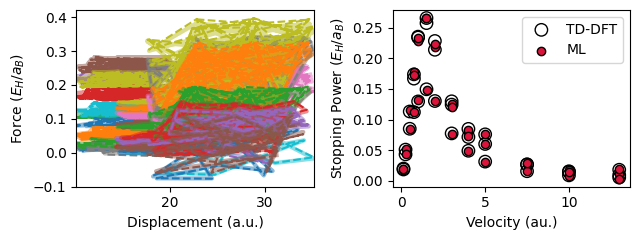

In [16]:
# Plot results
fig, axs = plt.subplots(1, 2)

velocity = []
stopping_pred = []
stopping_actual = []
for gid, group in channelling_data.groupby('directory'):
    # Store the velocity
    velocity.append(group['velocity_mag'].mean())

    # Plot the performance on a segment of the dataset
    label = 'v={:.1f}'.format(group['velocity_mag'].mean())

    for a in axs[:1]:
        my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                              label=label)

        a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)

        a.set_xlabel('Displacement (a.u.)')
        a.set_ylabel('Force ($E_H / a_B$)')

    # Store the stopping pwoers
    stopping_pred.append(group['force_fit'].mean())
    stopping_actual.append(group['force'].mean())
    
# Clean up the axis ranges
axs[0].set_xlim(channelling_data['displacement'].min(), channelling_data['displacement'].max())


# Plot the stopping power
axs[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
axs[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')

axs[1].set_ylabel('Stopping Power ($E_H / a_B$)')
axs[1].set_xlabel('Velocity (au.)')
#axs[1].set_ylim(0, max(axs[1].get_ylim()))
#axs[1].set_xlim(0, 4.2)
axs[1].legend()

fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
#fig.savefig(os.path.join('figures', 'train-random-predict-channel.png'), dpi=320)

stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
print(f'Mean percent error: {stopping_mape * 100:.2f}%')